# FUNCTIONS FOR DIFFERENT METRICS <a name="Top"></a>

Levels of metrics:
1. Difference between latitude and longitude values (Zindi challenge)
2. Air distance in kilometers
3. Road distance in kilometers
4. Driving distance in minutes
5. Evaluation of driving distance with threshold ("Golden Hour")

In this notebook we will use the Uber movement data to find distances between hexbins. To map the Uber movement data, Open Street Map data is used. For more on the Uber data read:
https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3
More on Open Street Map:
https://wiki.openstreetmap.org/wiki/Downloading_data


## Table of contents
***
[Imports and setup](#Imports_setup)<br>
[Extract, transform and load the data](#ETL)<br>
[Data analysis](#Data_analysis)<br>

</br>
</br>
</br>

## Imports and setup <a name="Imports_setup"></a>
***
### Importing packages

In [1]:
import pandas as pd
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import h3
from geopy.distance import geodesic

import sys
sys.path.insert(0, '../Scripts')
import capstone_functions as cf

### Setup

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

### Functions

In [3]:
def import_uber_data():
    '''Imports the hourly travel times from Uber movement data.
    In addition, the hexlusters used by Uber in Nairobi are imported. '''
    
    # Read the JSON file with the hexclusters
    file = open('../Inputs/540_hexclusters.json',)
    hexclusters = json.load(file)
    file.close()
    
    # Find the centroids of the hexbin clusters
    cluster_id = []
    longitude = []
    latitude = []
    for i in range(len(hexclusters['features'])):
        coords = hexclusters['features'][i]['geometry']['coordinates'][0]
        x = [long for long, lat in coords]
        y = [lat for long, lat in coords]
        x_c = sum(x) / len(x)
        y_c = sum(y) / len(y)
        cluster_id.append(hexclusters['features'][i]['properties']['MOVEMENT_ID'])
        longitude.append(x_c)
        latitude.append(y_c)
    
    # Create DataFrame with hexcluster ids and the lat and long values of the centroids
    global df_hexclusters
    df_hexclusters = pd.DataFrame([cluster_id, longitude, latitude]).transpose()
    df_hexclusters.columns = ['cluster_id', 'longitude', 'latitude']
    df_hexclusters['cluster_id'] = df_hexclusters['cluster_id'].astype('int')
    df_hexclusters = cf.assign_hex_bin(df_hexclusters, 'latitude', 'longitude')
    
    # Read the travel times for weekdays
    df_tt_hourly_wd = pd.read_csv('../Inputs/nairobi-hexclusters-2018-3-OnlyWeekdays-HourlyAggregate.csv')
    
    # Add lat and long values to the tavel time data
    global df_combined_wd
    df_combined_wd = df_tt_hourly_wd.merge(df_hexclusters, how='left', left_on='sourceid', right_on='cluster_id')
    df_combined_wd.drop(['cluster_id'], axis=1, inplace=True)
    df_combined_wd = df_combined_wd.merge(df_hexclusters, how='left', left_on='dstid', right_on='cluster_id', suffixes=('_source', '_dst'))
    df_combined_wd.drop(['cluster_id'], axis=1, inplace=True)
    df_combined_wd['dist_air'] = df_combined_wd[['latitude_source', 'longitude_source', 'latitude_dst', 'longitude_dst']].apply(lambda x: get_distance_air(x.latitude_source, x.longitude_source, x.latitude_dst, x.longitude_dst, h3res), axis=1)
    df_combined_wd['avg_speed'] = df_combined_wd['dist_air'] / df_combined_wd['mean_travel_time'] * 3600
    
    # Get average speeds per hour
    global avg_speeds_wd
    avg_speeds_wd = df_combined_wd.groupby('hod').mean()['avg_speed']
    
    # Read the travel times for weekends
    df_tt_hourly_we = pd.read_csv('../Inputs/nairobi-hexclusters-2018-3-OnlyWeekends-HourlyAggregate.csv')
    
    # Add lat and long values to the tavel time data
    global df_combined_we
    df_combined_we = df_tt_hourly_we.merge(df_hexclusters, how='left', left_on='sourceid', right_on='cluster_id')
    df_combined_we.drop(['cluster_id'], axis=1, inplace=True)
    df_combined_we = df_combined_we.merge(df_hexclusters, how='left', left_on='dstid', right_on='cluster_id', suffixes=('_source', '_dst'))
    df_combined_we.drop(['cluster_id'], axis=1, inplace=True)
    df_combined_we['dist_air'] = df_combined_we[['latitude_source', 'longitude_source', 'latitude_dst', 'longitude_dst']].apply(lambda x: get_distance_air(x.latitude_source, x.longitude_source, x.latitude_dst, x.longitude_dst, h3res), axis=1)
    df_combined_we['avg_speed'] = df_combined_we['dist_air'] / df_combined_we['mean_travel_time'] * 3600
    
    # Get average speeds per hour
    global avg_speeds_we
    avg_speeds_we = df_combined_we.groupby('hod').mean()['avg_speed']



def get_metrics(coord_src, coord_dst, weekend, hour):
    '''
    Inputs:
    * coord_src: H3 hexbin or coordinate as list or tuple of the origin of the trip
    * coord_dst: H3 hexbin or coordinate as list or tuple of the destination of the trip
    * weekend:   1 if weekend, 0 if weekday
    * hour:      Hour of the day as integer
    
    Output: Returns a list with the five levels of metics:
    * Zindi: Euklidean distance between latitude and longitude values (Zindi challenge)
    * Air: Air distance in kilometers
    * Road: Road distance in kilometers
    * Time: Driving distance in minutes
    * Golden: Binary value: False if driving distance below threshold ("Golden Hour"), True if above
    '''
    
    if type(coord_src) == str:
        lat_src = h3.h3_to_geo(coord_src)[0]
        long_src = h3.h3_to_geo(coord_src)[1]
        h3res = h3.h3_get_resolution(coord_src)
    elif type(coord_src) == list or tuple:
        lat_src = coord_src[0]
        long_src = coord_src[1]
        h3res = 0
    
    if type(coord_dst) == str:
        lat_dst = h3.h3_to_geo(coord_dst)[0]
        long_dst = h3.h3_to_geo(coord_dst)[1]
    elif type(coord_dst) == list or tuple:
        lat_dst = coord_dst[0]
        long_dst = coord_dst[1]
        
    metric = {}
    
    # Zindi score
    metric['Zindi'] = get_distance_zindi(lat_src, long_src, lat_dst, long_dst)
    
    # Air distance
    distance_air = get_distance_air(lat_src, long_src, lat_dst, long_dst, h3res)
    metric['Air'] = distance_air
    
    # Approximated road distance
    detour_coef = 1.3   # Known as Henning- or Hanno-coefficient
    metric['Road'] = distance_air * detour_coef
    
    # Travel time from Uber movement data
    travel_time = get_distance_time2(lat_src, long_src, lat_dst, long_dst, weekend, hour, h3res)
    metric['Time'] = travel_time
    
    # 'Golden hour'-threshold classification
    golden_hour = 60   # Minutes
    metric['Golden'] = travel_time > golden_hour
    
    return metric



def get_distance_zindi(lat_src, long_src, lat_dst, long_dst):
    '''
    Returns the Euklidean distance between latitude and longitude values like in the Zindi-score.
    '''
    
    return ((lat_src - lat_dst)**2 + (long_src - long_dst)**2) ** 0.5



def get_distance_air(lat_src, long_src, lat_dst, long_dst, h3res):
    '''
    Returns the Euklidean distance between two pairs of coordinates in km.
    If a distance between two points within a single cluster has to be calculated,
    the average distance of all possible distances within one cluster is returned.
    '''
    
    distance_air = geodesic((lat_src, long_src), (lat_dst, long_dst)).km
    
    if distance_air == 0:
        area = h3.hex_area(resolution = h3res)
        radius = (area / math.pi) ** 0.5
        distance_air = 128 / (45 * math.pi) * radius

    return distance_air



def get_distance_time(lat_src, long_src, lat_dst, long_dst, weekend, hour, h3res):
    '''
    Returns the time that is needed to cover the road distance between two pairs of coordinates in minutes based on the Uber movement data.
    '''
    
    hex_src = h3.geo_to_h3(lat=lat_src, lng=long_src, resolution=h3res)
    hex_dst = h3.geo_to_h3(lat=lat_dst, lng=long_dst, resolution=h3res)
    
    if weekend == 1:
        travel_times = df_combined_we[(df_combined_we['h3_zone_6_source'] == hex_src) & \
                                      (df_combined_we['h3_zone_6_dst'] == hex_dst) & \
                                      (df_combined_we['hod'] == hour) \
                                     ]['mean_travel_time']
    else:
        travel_times = df_combined_wd[(df_combined_wd['h3_zone_6_source'] == hex_src) & \
                                      (df_combined_wd['h3_zone_6_dst'] == hex_dst) & \
                                      (df_combined_wd['hod'] == hour) \
                                     ]['mean_travel_time']
    
    
    if len(travel_times) > 0:
        travel_time = sum(travel_times) / len(travel_times) / 60
    else:
        #print('Not in Uber movement data.')
        # len(travel_times) == 0 means that no travel times exist for this connection in the Uber movement data
        # Create list of closest hex-bin clusters to source
        if weekend == 1:
            valid_src = df_combined_we['h3_zone_6_source'].unique()
        else:
            valid_src = df_combined_wd['h3_zone_6_source'].unique()
        
        closest_hex_src = [(h3.geo_to_h3(lat_src, long_src, h3res), 0)]
        for src in valid_src:
            lat = h3.h3_to_geo(src)[0]
            long = h3.h3_to_geo(src)[1]
            dist = get_distance_air(lat_src, long_src, lat, long, h3res)
            closest_hex_src.append((src, dist))
        closest_hex_src.sort(key=lambda tup: tup[1])
        
        # Create list of closest hex-bin clusters to destination
        if weekend == 1:
            valid_dst = df_combined_we['h3_zone_6_dst'].unique()
        else:
            valid_dst = df_combined_wd['h3_zone_6_dst'].unique()
        
        closest_hex_dst = [(h3.geo_to_h3(lat_dst, long_dst, h3res), 0)]
        for dst in valid_dst:
            lat = h3.h3_to_geo(dst)[0]
            long = h3.h3_to_geo(dst)[1]
            dist = get_distance_air(lat_dst, long_dst, lat, long, h3res)
            closest_hex_dst.append((dst, dist))
        closest_hex_dst.sort(key=lambda tup: tup[1])
        
        # Run through the closest clusters and check if there is connection between them
        i_src = 0
        i_dst = 0
        if (closest_hex_src[1][1] - closest_hex_src[0][1]) > (closest_hex_dst[1][1] - closest_hex_dst[0][1]):
            i_src += 1
            switcher = 1
        else:
            i_dst += 1
            switcher = 0
        looking = True
        
        while looking:
            if weekend == 1:
                alt_times = df_combined_we[(df_combined_we['h3_zone_6_source'] == closest_hex_src[i_src][0]) & \
                                           (df_combined_we['h3_zone_6_dst'] == closest_hex_dst[i_dst][0]) & \
                                           (df_combined_we['hod'] == hour) \
                                          ]['mean_travel_time']
            else:
                alt_times = df_combined_wd[(df_combined_wd['h3_zone_6_source'] == closest_hex_src[i_src][0]) & \
                                           (df_combined_wd['h3_zone_6_dst'] == closest_hex_dst[i_dst][0]) & \
                                           (df_combined_wd['hod'] == hour) \
                                          ]['mean_travel_time']
            
            if len(alt_times) > 0:
                # Get average speed from this connection (based on air distance)
                alt_lat_src = h3.h3_to_geo(closest_hex_src[i_src][0])[0]
                alt_long_src = h3.h3_to_geo(closest_hex_src[i_src][0])[1]
                alt_lat_dst = h3.h3_to_geo(closest_hex_dst[i_dst][0])[0]
                alt_long_dst = h3.h3_to_geo(closest_hex_dst[i_dst][0])[1]
                
                alt_distance_air = get_distance_air(alt_lat_src, alt_long_src, alt_lat_dst, alt_long_dst, h3res)
                #print('alt_distance_air:', alt_distance_air, 'km')
                alt_time = sum(alt_times) / len(alt_times) / 60
                #print('alt_time:', alt_time, 'min')
                alt_speed = alt_distance_air / alt_time
                #print('alt_speed:', alt_speed*60, 'km/h')
                looking = False
                
            if switcher % 2 == 0:
                i_src += 1
            else:
                i_dst += 1
            switcher += 1
        
        # Get air distance between two original coordinates
        orig_dist = get_distance_air(lat_src, long_src, lat_dst, long_dst, h3res)
        #print('orig_dist:', orig_dist, 'km')
        
        # Divide air distance through average speed
        travel_time = orig_dist / alt_speed
    
    return travel_time



def get_distance_time2(lat_src, long_src, lat_dst, long_dst, weekend, hour, h3res):
    '''
    Returns the time that is needed to cover the road distance between two pairs of coordinates in minutes based on the Uber movement data.
    '''
    
    hex_src = h3.geo_to_h3(lat=lat_src, lng=long_src, resolution=h3res)
    hex_dst = h3.geo_to_h3(lat=lat_dst, lng=long_dst, resolution=h3res)
    
    if weekend == 1:
        travel_times = df_combined_we[(df_combined_we['h3_zone_6_source'] == hex_src) & \
                                      (df_combined_we['h3_zone_6_dst'] == hex_dst) & \
                                      (df_combined_we['hod'] == hour) \
                                     ]['mean_travel_time']
    else:
        travel_times = df_combined_wd[(df_combined_wd['h3_zone_6_source'] == hex_src) & \
                                      (df_combined_wd['h3_zone_6_dst'] == hex_dst) & \
                                      (df_combined_wd['hod'] == hour) \
                                     ]['mean_travel_time']
    
    
    if len(travel_times) > 0:
        travel_time = sum(travel_times) / len(travel_times) / 60
    else:
        # len(travel_times) == 0 means that no travel times exist for this connection in the Uber movement data
        # Get air distance between two original coordinates
        orig_dist = get_distance_air(lat_src, long_src, lat_dst, long_dst, h3res)
        
        # Divide air distance through average speed
        if weekend == 1:
            travel_time = orig_dist / avg_speeds_we[hour] * 60
        else:
            travel_time = orig_dist / avg_speeds_wd[hour] * 60
            
    return travel_time

[Back to top](#Top)<br>

</br>
</br>
</br>

## Extract, transform and load the data <a name="ETL"></a>
***

In [4]:
df_tt_hourly_wd = pd.read_csv('../Inputs/nairobi-hexclusters-2018-3-OnlyWeekdays-HourlyAggregate.csv')
print(df_tt_hourly_wd.shape)
df_tt_hourly_wd.head()

(733437, 7)


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,142,151,7,578.010,330.640,489.660,1.930
1,141,161,7,"2,752.360","1,111.310","2,567.360",1.440
2,281,145,20,"3,446.180",893.230,"3,328.070",1.310
3,130,271,7,"2,411.770",872.820,"2,258.800",1.440
4,133,241,7,"1,045.400",490.600,961.950,1.510


In [5]:
df_tt_hourly_we = pd.read_csv('../Inputs/nairobi-hexclusters-2018-3-OnlyWeekends-HourlyAggregate.csv')
print(df_tt_hourly_we.shape)
df_tt_hourly_we.head()

(628741, 7)


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,240,93,18,996.550,637.550,887.040,1.560
1,248,13,18,"1,280.250",324.370,"1,245.220",1.260
2,246,33,18,"2,482.390",629.630,"2,423.380",1.230
3,397,391,14,"1,600.820",478.980,"1,546.550",1.280
4,258,390,1,672.850,455.260,577.570,1.660


In [6]:
file = open('../Inputs/540_hexclusters.json',)
hexclusters = json.load(file)
file.close()
print(hexclusters['features'][0])

{'type': 'Feature', 'properties': {'MOVEMENT_ID': '1', 'DISPLAY_NAME': 'Unnamed Road'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[37.111174864587255, -1.054501278506145], [37.111211509652726, -1.052621942660184], [37.1095784810449, -1.051602301465064], [37.10961513834793, -1.049722999986327], [37.111284798057696, -1.048863352692155], [37.11132144139721, -1.046984098576995], [37.112991062092554, -1.046124483234446], [37.11302769146934, -1.044245276491278], [37.11139472635038, -1.04322567210167], [37.10972510680397, -1.04408525903768], [37.109688451227456, -1.045964478769177], [37.108018792669625, -1.046824097659419], [37.1063857908429, -1.045804468413923], [37.10471609443274, -1.046664090849479], [37.103083080959735, -1.045644452170056], [37.10141334670739, -1.046504078148562], [37.10137662476439, -1.048383371203796], [37.09970685151071, -1.049243029117883], [37.098073801369175, -1.048223365581039], [37.09640399028781, -1.049083027030353], [37.094770928526636, -1.048063354063948

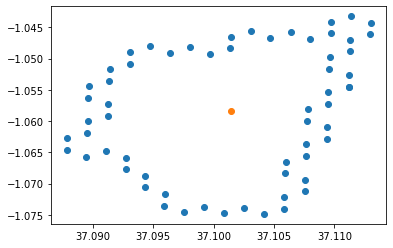

In [7]:
coords = hexclusters['features'][0]['geometry']['coordinates'][0]

x = [long for long, lat in coords]
y = [lat for long, lat in coords]

x_c = sum(x) / len(x)
y_c = sum(y) / len(y)

plt.scatter(x=x, y=y)
plt.scatter(x=x_c, y=y_c);

In [8]:
cluster_id = []
longitude = []
latitude = []

for i in range(len(hexclusters['features'])):
    coords = hexclusters['features'][i]['geometry']['coordinates'][0]
    x = [long for long, lat in coords]
    y = [lat for long, lat in coords]
    x_c = sum(x) / len(x)
    y_c = sum(y) / len(y)
    
    cluster_id.append(hexclusters['features'][i]['properties']['MOVEMENT_ID'])
    longitude.append(x_c)
    latitude.append(y_c)

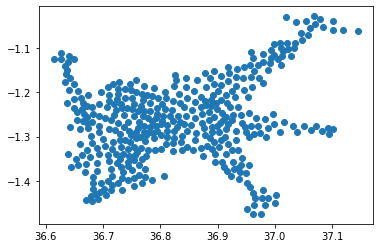

In [9]:
plt.scatter(x=longitude, y=latitude)

In [10]:
df_hexclusters = pd.DataFrame([cluster_id, longitude, latitude]).transpose()
df_hexclusters.columns = ['cluster_id', 'longitude', 'latitude']
df_hexclusters['cluster_id'] = df_hexclusters['cluster_id'].astype('int')
df_hexclusters = cf.assign_hex_bin(df_hexclusters, 'latitude', 'longitude')
print(df_hexclusters.shape)
df_hexclusters.head()

(400, 4)


,cluster_id,longitude,latitude,h3_zone_6
0,1,37.101,-1.058,867a4595fffffff
1,2,36.659,-1.316,867a6e097ffffff
2,3,36.656,-1.198,867a6e44fffffff
3,4,37.101,-1.039,867a4595fffffff
4,5,36.935,-1.331,867a6e51fffffff


In [11]:
df_hexclusters.nunique()

cluster_id    400
longitude     400
latitude      400
h3_zone_6      46
dtype: int64

[Back to top](#Top)<br>

</br>
</br>
</br>

## Data analysis <a name="Data_analysis"></a>
***

In [12]:
h3res = h3.h3_get_resolution(df_hexclusters.loc[0, 'h3_zone_6'])

df_combined_wd = df_tt_hourly_wd.merge(df_hexclusters, how='left', left_on='sourceid', right_on='cluster_id')
df_combined_wd.drop(['cluster_id'], axis=1, inplace=True)

df_combined_wd = df_combined_wd.merge(df_hexclusters, how='left', left_on='dstid', right_on='cluster_id', suffixes=('_source', '_dst'))
df_combined_wd.drop(['cluster_id'], axis=1, inplace=True)

df_combined_wd['dist_air'] = df_combined_wd[['latitude_source', 'longitude_source', 'latitude_dst', 'longitude_dst']].apply(lambda x: get_distance_air(x.latitude_source, x.longitude_source, x.latitude_dst, x.longitude_dst, h3res), axis=1)
df_combined_wd['avg_speed'] = df_combined_wd['dist_air'] / df_combined_wd['mean_travel_time'] * 3600

print(df_combined_wd.shape)
df_combined_wd.head()

(733437, 15)


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,longitude_source,latitude_source,h3_zone_6_source,longitude_dst,latitude_dst,h3_zone_6_dst,dist_air,avg_speed
0,142,151,7,578.010,330.640,489.660,1.930,36.792,-1.259,867a6e42fffffff,36.802,-1.273,867a6e42fffffff,1.866,11.620
1,141,161,7,"2,752.360","1,111.310","2,567.360",1.440,36.761,-1.281,867a6e55fffffff,36.906,-1.217,867a6e417ffffff,17.587,23.003
2,281,145,20,"3,446.180",893.230,"3,328.070",1.310,36.782,-1.278,867a6e55fffffff,36.938,-1.397,867a6e507ffffff,21.729,22.699
3,130,271,7,"2,411.770",872.820,"2,258.800",1.440,36.822,-1.333,867a6e557ffffff,36.811,-1.287,867a6e42fffffff,5.219,7.790
4,133,241,7,"1,045.400",490.600,961.950,1.510,36.811,-1.302,867a6e557ffffff,36.764,-1.300,867a6e55fffffff,5.197,17.895


In [13]:
avg_speeds_wd = df_combined_wd.groupby('hod').mean()['avg_speed']
avg_speeds_wd

hod
0    32.309
1    31.931
2    33.079
3    33.651
4    32.329
5    30.146
6    25.374
7    23.388
8    24.028
9    24.589
10   23.937
11   23.609
12   23.485
13   23.755
14   23.506
15   22.334
16   20.371
17   18.948
18   20.007
19   21.896
20   25.091
21   28.293
22   29.963
23   29.516
Name: avg_speed, dtype: float64

In [14]:
df_combined_we = df_tt_hourly_we.merge(df_hexclusters, how='left', left_on='sourceid', right_on='cluster_id')
df_combined_we.drop(['cluster_id'], axis=1, inplace=True)

df_combined_we = df_combined_we.merge(df_hexclusters, how='left', left_on='dstid', right_on='cluster_id', suffixes=('_source', '_dst'))
df_combined_we.drop(['cluster_id'], axis=1, inplace=True)

df_combined_we['dist_air'] = df_combined_we[['latitude_source', 'longitude_source', 'latitude_dst', 'longitude_dst']].apply(lambda x: get_distance_air(x.latitude_source, x.longitude_source, x.latitude_dst, x.longitude_dst, h3res), axis=1)
df_combined_we['avg_speed'] = df_combined_we['dist_air'] / df_combined_we['mean_travel_time'] * 3600

print(df_combined_we.shape)
df_combined_we.head()

(628741, 15)


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,longitude_source,latitude_source,h3_zone_6_source,longitude_dst,latitude_dst,h3_zone_6_dst,dist_air,avg_speed
0,240,93,18,996.550,637.550,887.040,1.560,36.716,-1.328,867a6e54fffffff,36.765,-1.325,867a6e55fffffff,5.543,20.025
1,248,13,18,"1,280.250",324.370,"1,245.220",1.260,36.785,-1.265,867a6e42fffffff,36.655,-1.262,867a6e46fffffff,14.476,40.707
2,246,33,18,"2,482.390",629.630,"2,423.380",1.230,36.895,-1.339,867a6e50fffffff,36.795,-1.212,867a6e40fffffff,17.887,25.940
3,397,391,14,"1,600.820",478.980,"1,546.550",1.280,36.822,-1.265,867a6e42fffffff,36.980,-1.132,867a6e4b7ffffff,22.957,51.627
4,258,390,1,672.850,455.260,577.570,1.660,36.812,-1.273,867a6e42fffffff,36.754,-1.254,867a6e477ffffff,6.823,36.507


In [15]:
avg_speeds_we = df_combined_we.groupby('hod').mean()['avg_speed']
avg_speeds_we

hod
0    30.955
1    31.295
2    31.420
3    31.653
4    31.033
5    30.927
6    33.035
7    31.679
8    28.906
9    26.834
10   25.684
11   24.879
12   24.587
13   23.887
14   23.518
15   24.960
16   25.638
17   26.112
18   24.846
19   23.837
20   26.140
21   28.012
22   29.391
23   29.532
Name: avg_speed, dtype: float64

In [16]:
get_distance_time(lat_src=53.561468372732406, long_src=9.915019036741262, lat_dst=-1.188850, long_dst=36.931382, weekend=1, hour=7, h3res=6)

6833.60380301183

In [17]:
get_distance_time2(lat_src=53.561468372732406, long_src=9.915019036741262, lat_dst=-1.188850, long_dst=36.931382, weekend=1, hour=7, h3res=6)

12432.912620806277

In [18]:
get_metrics((64.561468372732406, 9.915019036741262), (-1.188850, 36.931382), weekend=1, hour=7)

{'Zindi': 71.08437404857843,
 'Air': 7619.775067628051,
 'Road': 9905.707587916468,
 'Time': 14431.956610333718,
 'Golden': True}

In [19]:
get_metrics('867a6e55fffffff', '867a6e55fffffff', weekend=0, hour=1)

{'Zindi': 0.0,
 'Air': 3.0704422293562303,
 'Road': 3.9915748981630994,
 'Time': 10.113935309973055,
 'Golden': False}

In [47]:
lat_src = -1.328
long_src = 36.716
lat_dst = -1.188850
long_dst = 36.931382
hour = 5
h3res = 6

hex_src = h3.geo_to_h3(lat=lat_src, lng=long_src, resolution=h3res)
hex_dst = h3.geo_to_h3(lat=lat_dst, lng=long_dst, resolution=h3res)

df_combined_we[(df_combined_we['h3_zone_6_source'] == hex_src) & \
               (df_combined_we['h3_zone_6_dst'] == hex_dst) & \
               (df_combined_we['hod'] == hour) \
              ]['mean_travel_time']

Series([], Name: mean_travel_time, dtype: float64)

[Back to top](#Top)<br>